# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import gzip
import os
import tempfile
from pathlib import Path

import numpy as np
import pooch
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data acquisition

First we download a sample multiome dataset from 10X. We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.

```{important}
MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.
```

In [5]:
def download_data(save_path: str, fname: str = "pbmc_10k"):
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz",
        known_hash="872b0dba467d972aa498812a857677ca7cf69050d4f9762b2cd4753b2be694a1",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    data_paths.sort()

    for path in data_paths:
        with gzip.open(path, "rb") as f_in:
            with open(path.replace(".gz", ""), "wb") as f_out:
                f_out.write(f_in.read())

    return str(Path(data_paths[0]).parent)

In [6]:
data_path = download_data(save_dir.name)

  0%|                                               | 0.00/375M [00:00<?, ?B/s]

  1%|▏                                     | 2.26M/375M [00:00<00:16, 22.6MB/s]

  2%|▊                                     | 7.90M/375M [00:00<00:15, 23.0MB/s]

  4%|█▋                                    | 16.5M/375M [00:00<00:14, 24.8MB/s]

  6%|██▎                                   | 22.9M/375M [00:00<00:11, 31.1MB/s]

  7%|██▋                                   | 26.4M/375M [00:01<00:14, 24.2MB/s]

  8%|███▏                                  | 31.2M/375M [00:01<00:15, 21.7MB/s]

  9%|███▍                                  | 33.6M/375M [00:01<00:18, 18.3MB/s]

 10%|███▉                                  | 38.4M/375M [00:01<00:17, 19.4MB/s]

 11%|████▏                                 | 40.9M/375M [00:02<00:20, 16.1MB/s]

 12%|████▌                                 | 45.6M/375M [00:02<00:16, 19.8MB/s]

 13%|████▊                                 | 47.9M/375M [00:02<00:19, 17.1MB/s]

 15%|█████▊                                | 57.2M/375M [00:02<00:10, 30.2MB/s]

 16%|██████▏                               | 61.3M/375M [00:02<00:11, 27.8MB/s]

 17%|██████▌                               | 64.9M/375M [00:02<00:11, 27.1MB/s]

 18%|██████▉                               | 68.1M/375M [00:02<00:12, 24.1MB/s]

 19%|███████▎                              | 72.2M/375M [00:03<00:12, 25.2MB/s]

 20%|███████▌                              | 75.0M/375M [00:03<00:15, 18.9MB/s]

 21%|████████                              | 79.7M/375M [00:03<00:13, 22.7MB/s]

 22%|████████▎                             | 82.4M/375M [00:03<00:16, 17.9MB/s]

 23%|████████▊                             | 87.3M/375M [00:03<00:14, 20.5MB/s]

 24%|█████████                             | 90.1M/375M [00:04<00:17, 16.1MB/s]

 26%|█████████▊                            | 97.4M/375M [00:04<00:11, 25.1MB/s]

 27%|██████████▍                            | 101M/375M [00:04<00:12, 22.6MB/s]

 28%|██████████▉                            | 105M/375M [00:04<00:11, 22.7MB/s]

 29%|███████████▏                           | 108M/375M [00:04<00:13, 20.1MB/s]

 31%|███████████▉                           | 114M/375M [00:05<00:09, 28.3MB/s]

 31%|████████████▎                          | 118M/375M [00:05<00:10, 25.2MB/s]

 32%|████████████▋                          | 122M/375M [00:05<00:10, 23.5MB/s]

 35%|█████████████▌                         | 130M/375M [00:05<00:08, 29.3MB/s]

 37%|██████████████▎                        | 138M/375M [00:05<00:07, 30.4MB/s]

 38%|██████████████▋                        | 141M/375M [00:06<00:09, 24.6MB/s]

 38%|██████████████▉                        | 144M/375M [00:06<00:11, 20.3MB/s]

 39%|███████████████▎                       | 148M/375M [00:06<00:11, 19.6MB/s]

 41%|███████████████▉                       | 153M/375M [00:06<00:09, 23.4MB/s]

 41%|████████████████▏                      | 155M/375M [00:06<00:10, 20.0MB/s]

 43%|████████████████▉                      | 163M/375M [00:07<00:07, 29.5MB/s]

 44%|█████████████████▎                     | 166M/375M [00:07<00:08, 23.5MB/s]

 46%|█████████████████▉                     | 173M/375M [00:07<00:08, 23.9MB/s]

 47%|██████████████████▌                    | 178M/375M [00:07<00:06, 28.6MB/s]

 48%|██████████████████▉                    | 182M/375M [00:07<00:07, 26.0MB/s]

 49%|███████████████████▎                   | 185M/375M [00:08<00:08, 23.4MB/s]

 50%|███████████████████▌                   | 189M/375M [00:08<00:09, 19.8MB/s]

 52%|████████████████████▎                  | 196M/375M [00:08<00:07, 24.8MB/s]

 54%|█████████████████████▏                 | 204M/375M [00:08<00:05, 34.1MB/s]

 55%|█████████████████████▋                 | 208M/375M [00:08<00:05, 29.7MB/s]

 57%|██████████████████████                 | 212M/375M [00:08<00:05, 31.6MB/s]

 58%|██████████████████████▍                | 216M/375M [00:09<00:06, 24.5MB/s]

 59%|██████████████████████▉                | 220M/375M [00:09<00:05, 26.2MB/s]

 60%|███████████████████████▏               | 223M/375M [00:09<00:07, 19.6MB/s]

 60%|███████████████████████▌               | 226M/375M [00:09<00:09, 16.5MB/s]

 61%|███████████████████████▋               | 228M/375M [00:10<00:10, 13.5MB/s]

 62%|████████████████████████▏              | 233M/375M [00:10<00:07, 18.4MB/s]

 63%|████████████████████████▍              | 235M/375M [00:10<00:08, 17.4MB/s]

 63%|████████████████████████▋              | 238M/375M [00:10<00:08, 16.8MB/s]

 65%|█████████████████████████▍             | 245M/375M [00:10<00:05, 24.3MB/s]

 67%|██████████████████████████             | 251M/375M [00:10<00:04, 27.9MB/s]

 68%|██████████████████████████▍            | 254M/375M [00:11<00:05, 22.6MB/s]

 70%|███████████████████████████▏           | 262M/375M [00:11<00:04, 24.5MB/s]

 72%|███████████████████████████▉           | 268M/375M [00:11<00:04, 21.9MB/s]

 72%|████████████████████████████▏          | 271M/375M [00:11<00:05, 18.3MB/s]

 74%|████████████████████████████▊          | 278M/375M [00:12<00:04, 21.7MB/s]

 75%|█████████████████████████████▍         | 283M/375M [00:12<00:03, 24.8MB/s]

 76%|█████████████████████████████▋         | 286M/375M [00:12<00:04, 21.6MB/s]

 78%|██████████████████████████████▎        | 292M/375M [00:12<00:03, 24.0MB/s]

 80%|███████████████████████████████▏       | 300M/375M [00:12<00:02, 29.2MB/s]

 81%|███████████████████████████████▍       | 303M/375M [00:13<00:03, 23.0MB/s]

 83%|████████████████████████████████▎      | 311M/375M [00:13<00:02, 31.5MB/s]

 84%|████████████████████████████████▋      | 315M/375M [00:13<00:02, 27.7MB/s]

 85%|█████████████████████████████████      | 318M/375M [00:13<00:02, 27.7MB/s]

 86%|█████████████████████████████████▍     | 321M/375M [00:13<00:02, 21.9MB/s]

 87%|█████████████████████████████████▊     | 325M/375M [00:14<00:02, 19.9MB/s]

 89%|██████████████████████████████████▋    | 334M/375M [00:14<00:01, 24.8MB/s]

 91%|███████████████████████████████████▌   | 342M/375M [00:14<00:01, 29.4MB/s]

 92%|███████████████████████████████████▉   | 346M/375M [00:14<00:01, 25.8MB/s]

 93%|████████████████████████████████████▍  | 350M/375M [00:14<00:00, 29.3MB/s]

 94%|████████████████████████████████████▊  | 354M/375M [00:15<00:00, 26.5MB/s]

 95%|█████████████████████████████████████  | 357M/375M [00:15<00:00, 24.3MB/s]

 96%|█████████████████████████████████████▍ | 360M/375M [00:15<00:00, 20.2MB/s]

 97%|█████████████████████████████████████▉ | 365M/375M [00:15<00:00, 24.8MB/s]

  0%|                                               | 0.00/375M [00:00<?, ?B/s]

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 841GB/s]

Untarring contents of '/tmp/tmpwnsimol3/pbmc_10k' to '/tmp/tmpwnsimol3/pbmc_10k.untar'


## Data Processing

Next, we'll read the data into an Anndata object. We'll then split the data to three datasets, and remove some modality-specific data from parts of the dataset, to demonstrate how MultIVI mixes multimodal and single-modal data.
The data has 12012 cells, we'll use 4004 for each dataset.

Reading the data into an AnnData object can be done with the `read_10x_multiome` function:

In [7]:
# read multiomic data
adata = scvi.data.read_10x_multiome(data_path)
adata.var_names_make_unique()

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We can now split the dataset to three datasets, and remove a modality from two of them, so we'll have equal-sized (4004 cells in each) datasets with multiome, expression-only, and accessibility-only observations:

In [8]:
# split to three datasets by modality (RNA, ATAC, Multiome), and corrupt data
# by remove some data to create single-modality data
n = 4004
adata_rna = adata[:n, adata.var.modality == "Gene Expression"].copy()
adata_paired = adata[n : 2 * n].copy()
adata_atac = adata[2 * n :, adata.var.modality == "Peaks"].copy()

We can then use the `organize_multiome_anndatas` function to orgnize these three datasets into a single Multiome dataset.
This function sorts and orders the data from the multi-modal and modality-specific AnnDatas into a single AnnData (aligning the features, padding missing modalities with 0s, etc).

In [9]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

/env/lib/python3.11/site-packages/scvi/data/_preprocessing.py:321: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return multi_anndata.concatenate(other, join="outer", batch_key=modality_key)


/env/lib/python3.11/site-packages/scvi/data/_preprocessing.py:321: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return multi_anndata.concatenate(other, join="outer", batch_key=modality_key)


Note that `organize_multiome_anndatas` adds an annotation to the cells to indicate which modality they originate from:

In [10]:
adata_mvi.obs

,batch_id,modality
CCGCTAAAGGGCCATC_paired,1,paired
CCGCTAAAGTCTTGAA_paired,1,paired
CCGCTAAAGTTAGACC_paired,1,paired
CCGCTAAAGTTCCCAC_paired,1,paired
CCGCTAAAGTTTGCGG_paired,1,paired
...,...,...
TTTGTTGGTACGCGCA_accessibility,1,accessibility
TTTGTTGGTATTTGCC_accessibility,1,accessibility
TTTGTTGGTGATTACG_accessibility,1,accessibility
TTTGTTGGTTTCAGGA_accessibility,1,accessibility


```{important}
MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.
```

MultiVI requires the features to be ordered, such that genes appear before genomic regions. In this case this is already the case, but it's always good to verify:

In [11]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,ID,modality,chr,start,end
MIR1302-2HG,ENSG00000243485,Gene Expression,chr1,29553,30267
AL391261.2,ENSG00000258847,Gene Expression,chr14,66004522,66004523
FUT8-AS1,ENSG00000276116,Gene Expression,chr14,65412689,65412690
FUT8,ENSG00000033170,Gene Expression,chr14,65410591,65413008
AL355076.2,ENSG00000258760,Gene Expression,chr14,65302679,65318790
...,...,...,...,...,...
chr15:101277030-101277907,chr15:101277030-101277907,Peaks,chr15,101277030,101277907
chr15:101257856-101258771,chr15:101257856-101258771,Peaks,chr15,101257856,101258771
chr15:101251516-101252373,chr15:101251516-101252373,Peaks,chr15,101251516,101252373
chr15:101397608-101398445,chr15:101397608-101398445,Peaks,chr15,101397608,101398445


We also filter features to remove those that appear in fewer than 1% of the cells

In [12]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(12012, 148458)


(12012, 80878)


## Setup and Training MultiVI

We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_anndata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

```{important}
MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.
```

In [13]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key="modality")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [14]:
model = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["modality"] == "Gene Expression").sum(),
    n_regions=(adata_mvi.var["modality"] == "Peaks").sum(),
)
model.view_anndata_setup()

/env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.1.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   3   │
│         n_cells          │ 12012 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 80878 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

In [15]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 1/500 [00:03<31:58,  3.85s/it]

Epoch 1/500:   0%|          | 1/500 [00:03<31:58,  3.85s/it, v_num=1, train_loss_step=2.16e+4, train_loss_epoch=2.46e+4]

Epoch 2/500:   0%|          | 1/500 [00:03<31:58,  3.85s/it, v_num=1, train_loss_step=2.16e+4, train_loss_epoch=2.46e+4]

Epoch 2/500:   0%|          | 2/500 [00:07<29:15,  3.52s/it, v_num=1, train_loss_step=2.16e+4, train_loss_epoch=2.46e+4]

Epoch 2/500:   0%|          | 2/500 [00:07<29:15,  3.52s/it, v_num=1, train_loss_step=1.73e+4, train_loss_epoch=1.79e+4]

Epoch 3/500:   0%|          | 2/500 [00:07<29:15,  3.52s/it, v_num=1, train_loss_step=1.73e+4, train_loss_epoch=1.79e+4]

Epoch 3/500:   1%|          | 3/500 [00:10<28:17,  3.42s/it, v_num=1, train_loss_step=1.73e+4, train_loss_epoch=1.79e+4]

Epoch 3/500:   1%|          | 3/500 [00:10<28:17,  3.42s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.59e+4]

Epoch 4/500:   1%|          | 3/500 [00:10<28:17,  3.42s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.59e+4]

Epoch 4/500:   1%|          | 4/500 [00:13<27:49,  3.37s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.59e+4]

Epoch 4/500:   1%|          | 4/500 [00:13<27:49,  3.37s/it, v_num=1, train_loss_step=1.49e+4, train_loss_epoch=1.51e+4]

Epoch 5/500:   1%|          | 4/500 [00:13<27:49,  3.37s/it, v_num=1, train_loss_step=1.49e+4, train_loss_epoch=1.51e+4]

Epoch 5/500:   1%|          | 5/500 [00:17<27:34,  3.34s/it, v_num=1, train_loss_step=1.49e+4, train_loss_epoch=1.51e+4]

Epoch 5/500:   1%|          | 5/500 [00:17<27:34,  3.34s/it, v_num=1, train_loss_step=1.58e+4, train_loss_epoch=1.49e+4]

Epoch 6/500:   1%|          | 5/500 [00:17<27:34,  3.34s/it, v_num=1, train_loss_step=1.58e+4, train_loss_epoch=1.49e+4]

Epoch 6/500:   1%|          | 6/500 [00:20<27:24,  3.33s/it, v_num=1, train_loss_step=1.58e+4, train_loss_epoch=1.49e+4]

Epoch 6/500:   1%|          | 6/500 [00:20<27:24,  3.33s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.47e+4]

Epoch 7/500:   1%|          | 6/500 [00:20<27:24,  3.33s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.47e+4]

Epoch 7/500:   1%|▏         | 7/500 [00:23<27:21,  3.33s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.47e+4]

Epoch 7/500:   1%|▏         | 7/500 [00:23<27:21,  3.33s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.44e+4]

Epoch 8/500:   1%|▏         | 7/500 [00:23<27:21,  3.33s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.44e+4]

Epoch 8/500:   2%|▏         | 8/500 [00:26<27:17,  3.33s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.44e+4]

Epoch 8/500:   2%|▏         | 8/500 [00:26<27:17,  3.33s/it, v_num=1, train_loss_step=1.56e+4, train_loss_epoch=1.43e+4]

Epoch 9/500:   2%|▏         | 8/500 [00:26<27:17,  3.33s/it, v_num=1, train_loss_step=1.56e+4, train_loss_epoch=1.43e+4]

Epoch 9/500:   2%|▏         | 9/500 [00:30<27:13,  3.33s/it, v_num=1, train_loss_step=1.56e+4, train_loss_epoch=1.43e+4]

Epoch 9/500:   2%|▏         | 9/500 [00:30<27:13,  3.33s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.42e+4]

Epoch 10/500:   2%|▏         | 9/500 [00:30<27:13,  3.33s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.42e+4]

Epoch 10/500:   2%|▏         | 10/500 [00:33<27:10,  3.33s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.42e+4]

Epoch 10/500:   2%|▏         | 10/500 [00:33<27:10,  3.33s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.41e+4]

Epoch 11/500:   2%|▏         | 10/500 [00:33<27:10,  3.33s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.41e+4]

Epoch 11/500:   2%|▏         | 11/500 [00:36<27:06,  3.33s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.41e+4]

Epoch 11/500:   2%|▏         | 11/500 [00:36<27:06,  3.33s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.4e+4] 

Epoch 12/500:   2%|▏         | 11/500 [00:36<27:06,  3.33s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.4e+4]

Epoch 12/500:   2%|▏         | 12/500 [00:40<27:01,  3.32s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.4e+4]

Epoch 12/500:   2%|▏         | 12/500 [00:40<27:01,  3.32s/it, v_num=1, train_loss_step=1.55e+4, train_loss_epoch=1.4e+4]

Epoch 13/500:   2%|▏         | 12/500 [00:40<27:01,  3.32s/it, v_num=1, train_loss_step=1.55e+4, train_loss_epoch=1.4e+4]

Epoch 13/500:   3%|▎         | 13/500 [00:43<26:56,  3.32s/it, v_num=1, train_loss_step=1.55e+4, train_loss_epoch=1.4e+4]

Epoch 13/500:   3%|▎         | 13/500 [00:43<26:56,  3.32s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.4e+4]

Epoch 14/500:   3%|▎         | 13/500 [00:43<26:56,  3.32s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.4e+4]

Epoch 14/500:   3%|▎         | 14/500 [00:46<26:54,  3.32s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.4e+4]

Epoch 14/500:   3%|▎         | 14/500 [00:46<26:54,  3.32s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.39e+4]

Epoch 15/500:   3%|▎         | 14/500 [00:46<26:54,  3.32s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.39e+4]

Epoch 15/500:   3%|▎         | 15/500 [00:50<26:51,  3.32s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.39e+4]

Epoch 15/500:   3%|▎         | 15/500 [00:50<26:51,  3.32s/it, v_num=1, train_loss_step=1.57e+4, train_loss_epoch=1.39e+4]

Epoch 16/500:   3%|▎         | 15/500 [00:50<26:51,  3.32s/it, v_num=1, train_loss_step=1.57e+4, train_loss_epoch=1.39e+4]

Epoch 16/500:   3%|▎         | 16/500 [00:53<26:48,  3.32s/it, v_num=1, train_loss_step=1.57e+4, train_loss_epoch=1.39e+4]

Epoch 16/500:   3%|▎         | 16/500 [00:53<26:48,  3.32s/it, v_num=1, train_loss_step=1.49e+4, train_loss_epoch=1.39e+4]

Epoch 17/500:   3%|▎         | 16/500 [00:53<26:48,  3.32s/it, v_num=1, train_loss_step=1.49e+4, train_loss_epoch=1.39e+4]

Epoch 17/500:   3%|▎         | 17/500 [00:56<26:45,  3.32s/it, v_num=1, train_loss_step=1.49e+4, train_loss_epoch=1.39e+4]

Epoch 17/500:   3%|▎         | 17/500 [00:56<26:45,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.38e+4]

Epoch 18/500:   3%|▎         | 17/500 [00:56<26:45,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.38e+4]

Epoch 18/500:   4%|▎         | 18/500 [01:00<26:42,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.38e+4]

Epoch 18/500:   4%|▎         | 18/500 [01:00<26:42,  3.32s/it, v_num=1, train_loss_step=1.55e+4, train_loss_epoch=1.38e+4]

Epoch 19/500:   4%|▎         | 18/500 [01:00<26:42,  3.32s/it, v_num=1, train_loss_step=1.55e+4, train_loss_epoch=1.38e+4]

Epoch 19/500:   4%|▍         | 19/500 [01:03<26:39,  3.32s/it, v_num=1, train_loss_step=1.55e+4, train_loss_epoch=1.38e+4]

Epoch 19/500:   4%|▍         | 19/500 [01:03<26:39,  3.32s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.38e+4]

Epoch 20/500:   4%|▍         | 19/500 [01:03<26:39,  3.32s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.38e+4]

Epoch 20/500:   4%|▍         | 20/500 [01:06<26:36,  3.33s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.38e+4]

Epoch 20/500:   4%|▍         | 20/500 [01:06<26:36,  3.33s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.38e+4]

Epoch 21/500:   4%|▍         | 20/500 [01:06<26:36,  3.33s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.38e+4]

Epoch 21/500:   4%|▍         | 21/500 [01:10<26:32,  3.33s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.38e+4]

Epoch 21/500:   4%|▍         | 21/500 [01:10<26:32,  3.33s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.38e+4]

Epoch 22/500:   4%|▍         | 21/500 [01:10<26:32,  3.33s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.38e+4]

Epoch 22/500:   4%|▍         | 22/500 [01:13<26:28,  3.32s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.38e+4]

Epoch 22/500:   4%|▍         | 22/500 [01:13<26:28,  3.32s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.38e+4]

Epoch 23/500:   4%|▍         | 22/500 [01:13<26:28,  3.32s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.38e+4]

Epoch 23/500:   5%|▍         | 23/500 [01:16<26:25,  3.32s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.38e+4]

Epoch 23/500:   5%|▍         | 23/500 [01:16<26:25,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.38e+4]

Epoch 24/500:   5%|▍         | 23/500 [01:16<26:25,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.38e+4]

Epoch 24/500:   5%|▍         | 24/500 [01:20<26:22,  3.33s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.38e+4]

Epoch 24/500:   5%|▍         | 24/500 [01:20<26:22,  3.33s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.37e+4]

Epoch 25/500:   5%|▍         | 24/500 [01:20<26:22,  3.33s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.37e+4]

Epoch 25/500:   5%|▌         | 25/500 [01:23<26:17,  3.32s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.37e+4]

Epoch 25/500:   5%|▌         | 25/500 [01:23<26:17,  3.32s/it, v_num=1, train_loss_step=1.64e+4, train_loss_epoch=1.37e+4]

Epoch 26/500:   5%|▌         | 25/500 [01:23<26:17,  3.32s/it, v_num=1, train_loss_step=1.64e+4, train_loss_epoch=1.37e+4]

Epoch 26/500:   5%|▌         | 26/500 [01:26<26:06,  3.31s/it, v_num=1, train_loss_step=1.64e+4, train_loss_epoch=1.37e+4]

Epoch 26/500:   5%|▌         | 26/500 [01:26<26:06,  3.31s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.37e+4] 

Epoch 27/500:   5%|▌         | 26/500 [01:26<26:06,  3.31s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.37e+4]

Epoch 27/500:   5%|▌         | 27/500 [01:30<25:58,  3.29s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.37e+4]

Epoch 27/500:   5%|▌         | 27/500 [01:30<25:58,  3.29s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.37e+4]

Epoch 28/500:   5%|▌         | 27/500 [01:30<25:58,  3.29s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.37e+4]

Epoch 28/500:   6%|▌         | 28/500 [01:33<25:50,  3.29s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.37e+4]

Epoch 28/500:   6%|▌         | 28/500 [01:33<25:50,  3.29s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.37e+4]

Epoch 29/500:   6%|▌         | 28/500 [01:33<25:50,  3.29s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.37e+4]

Epoch 29/500:   6%|▌         | 29/500 [01:36<25:46,  3.28s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.37e+4]

Epoch 29/500:   6%|▌         | 29/500 [01:36<25:46,  3.28s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.37e+4]

Epoch 30/500:   6%|▌         | 29/500 [01:36<25:46,  3.28s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.37e+4]

Epoch 30/500:   6%|▌         | 30/500 [01:39<25:49,  3.30s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.37e+4]

Epoch 30/500:   6%|▌         | 30/500 [01:39<25:49,  3.30s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.37e+4] 

Epoch 31/500:   6%|▌         | 30/500 [01:39<25:49,  3.30s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.37e+4]

Epoch 31/500:   6%|▌         | 31/500 [01:43<25:51,  3.31s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.37e+4]

Epoch 31/500:   6%|▌         | 31/500 [01:43<25:51,  3.31s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.37e+4]

Epoch 32/500:   6%|▌         | 31/500 [01:43<25:51,  3.31s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.37e+4]

Epoch 32/500:   6%|▋         | 32/500 [01:46<25:51,  3.32s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.37e+4]

Epoch 32/500:   6%|▋         | 32/500 [01:46<25:51,  3.32s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.37e+4]

Epoch 33/500:   6%|▋         | 32/500 [01:46<25:51,  3.32s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.37e+4]

Epoch 33/500:   7%|▋         | 33/500 [01:49<25:49,  3.32s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.37e+4]

Epoch 33/500:   7%|▋         | 33/500 [01:49<25:49,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.37e+4]

Epoch 34/500:   7%|▋         | 33/500 [01:49<25:49,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.37e+4]

Epoch 34/500:   7%|▋         | 34/500 [01:53<25:47,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.37e+4]

Epoch 34/500:   7%|▋         | 34/500 [01:53<25:47,  3.32s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.37e+4]

Epoch 35/500:   7%|▋         | 34/500 [01:53<25:47,  3.32s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.37e+4]

Epoch 35/500:   7%|▋         | 35/500 [01:56<25:41,  3.32s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.37e+4]

Epoch 35/500:   7%|▋         | 35/500 [01:56<25:41,  3.32s/it, v_num=1, train_loss_step=1.39e+4, train_loss_epoch=1.37e+4]

Epoch 36/500:   7%|▋         | 35/500 [01:56<25:41,  3.32s/it, v_num=1, train_loss_step=1.39e+4, train_loss_epoch=1.37e+4]

Epoch 36/500:   7%|▋         | 36/500 [01:59<25:38,  3.32s/it, v_num=1, train_loss_step=1.39e+4, train_loss_epoch=1.37e+4]

Epoch 36/500:   7%|▋         | 36/500 [01:59<25:38,  3.32s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.37e+4]

Epoch 37/500:   7%|▋         | 36/500 [01:59<25:38,  3.32s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.37e+4]

Epoch 37/500:   7%|▋         | 37/500 [02:03<25:35,  3.32s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.37e+4]

Epoch 37/500:   7%|▋         | 37/500 [02:03<25:35,  3.32s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 38/500:   7%|▋         | 37/500 [02:03<25:35,  3.32s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 38/500:   8%|▊         | 38/500 [02:06<25:32,  3.32s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 38/500:   8%|▊         | 38/500 [02:06<25:32,  3.32s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.36e+4]

Epoch 39/500:   8%|▊         | 38/500 [02:06<25:32,  3.32s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.36e+4]

Epoch 39/500:   8%|▊         | 39/500 [02:09<25:30,  3.32s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.36e+4]

Epoch 39/500:   8%|▊         | 39/500 [02:09<25:30,  3.32s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.36e+4]

Epoch 40/500:   8%|▊         | 39/500 [02:09<25:30,  3.32s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.36e+4]

Epoch 40/500:   8%|▊         | 40/500 [02:13<25:28,  3.32s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.36e+4]

Epoch 40/500:   8%|▊         | 40/500 [02:13<25:28,  3.32s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 41/500:   8%|▊         | 40/500 [02:13<25:28,  3.32s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 41/500:   8%|▊         | 41/500 [02:16<25:29,  3.33s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 41/500:   8%|▊         | 41/500 [02:16<25:29,  3.33s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.36e+4] 

Epoch 42/500:   8%|▊         | 41/500 [02:16<25:29,  3.33s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.36e+4]

Epoch 42/500:   8%|▊         | 42/500 [02:19<25:29,  3.34s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.36e+4]

Epoch 42/500:   8%|▊         | 42/500 [02:19<25:29,  3.34s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 43/500:   8%|▊         | 42/500 [02:19<25:29,  3.34s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 43/500:   9%|▊         | 43/500 [02:23<25:28,  3.34s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 43/500:   9%|▊         | 43/500 [02:23<25:28,  3.34s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.36e+4]

Epoch 44/500:   9%|▊         | 43/500 [02:23<25:28,  3.34s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.36e+4]

Epoch 44/500:   9%|▉         | 44/500 [02:26<25:27,  3.35s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.36e+4]

Epoch 44/500:   9%|▉         | 44/500 [02:26<25:27,  3.35s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 45/500:   9%|▉         | 44/500 [02:26<25:27,  3.35s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 45/500:   9%|▉         | 45/500 [02:29<25:24,  3.35s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 45/500:   9%|▉         | 45/500 [02:29<25:24,  3.35s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.36e+4]

Epoch 46/500:   9%|▉         | 45/500 [02:29<25:24,  3.35s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.36e+4]

Epoch 46/500:   9%|▉         | 46/500 [02:33<25:21,  3.35s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.36e+4]

Epoch 46/500:   9%|▉         | 46/500 [02:33<25:21,  3.35s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 47/500:   9%|▉         | 46/500 [02:33<25:21,  3.35s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 47/500:   9%|▉         | 47/500 [02:36<25:18,  3.35s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 47/500:   9%|▉         | 47/500 [02:36<25:18,  3.35s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.36e+4]

Epoch 48/500:   9%|▉         | 47/500 [02:36<25:18,  3.35s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.36e+4]

Epoch 48/500:  10%|▉         | 48/500 [02:39<25:16,  3.35s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.36e+4]

Epoch 48/500:  10%|▉         | 48/500 [02:39<25:16,  3.35s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 49/500:  10%|▉         | 48/500 [02:39<25:16,  3.35s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 49/500:  10%|▉         | 49/500 [02:43<25:13,  3.36s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 49/500:  10%|▉         | 49/500 [02:43<25:13,  3.36s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 50/500:  10%|▉         | 49/500 [02:43<25:13,  3.36s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 50/500:  10%|█         | 50/500 [02:46<25:10,  3.36s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.36e+4]

Epoch 50/500:  10%|█         | 50/500 [02:46<25:10,  3.36s/it, v_num=1, train_loss_step=1.59e+4, train_loss_epoch=1.36e+4]

Epoch 51/500:  10%|█         | 50/500 [02:46<25:10,  3.36s/it, v_num=1, train_loss_step=1.59e+4, train_loss_epoch=1.36e+4]

Epoch 51/500:  10%|█         | 51/500 [02:50<25:07,  3.36s/it, v_num=1, train_loss_step=1.59e+4, train_loss_epoch=1.36e+4]

Epoch 51/500:  10%|█         | 51/500 [02:50<25:07,  3.36s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.36e+4]

Epoch 52/500:  10%|█         | 51/500 [02:50<25:07,  3.36s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.36e+4]

Epoch 52/500:  10%|█         | 52/500 [02:53<25:06,  3.36s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.36e+4]

Epoch 52/500:  10%|█         | 52/500 [02:53<25:06,  3.36s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.36e+4]

Epoch 53/500:  10%|█         | 52/500 [02:53<25:06,  3.36s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.36e+4]

Epoch 53/500:  11%|█         | 53/500 [02:56<25:04,  3.36s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.36e+4]

Epoch 53/500:  11%|█         | 53/500 [02:56<25:04,  3.36s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.36e+4]

Epoch 54/500:  11%|█         | 53/500 [02:56<25:04,  3.36s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.36e+4]

Epoch 54/500:  11%|█         | 54/500 [03:00<25:00,  3.36s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.36e+4]

Epoch 54/500:  11%|█         | 54/500 [03:00<25:00,  3.36s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 55/500:  11%|█         | 54/500 [03:00<25:00,  3.36s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 55/500:  11%|█         | 55/500 [03:03<24:58,  3.37s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4]

Epoch 55/500:  11%|█         | 55/500 [03:03<24:58,  3.37s/it, v_num=1, train_loss_step=1.18e+4, train_loss_epoch=1.36e+4]

Epoch 56/500:  11%|█         | 55/500 [03:03<24:58,  3.37s/it, v_num=1, train_loss_step=1.18e+4, train_loss_epoch=1.36e+4]

Epoch 56/500:  11%|█         | 56/500 [03:06<24:56,  3.37s/it, v_num=1, train_loss_step=1.18e+4, train_loss_epoch=1.36e+4]

Epoch 56/500:  11%|█         | 56/500 [03:06<24:56,  3.37s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.36e+4]

Epoch 57/500:  11%|█         | 56/500 [03:06<24:56,  3.37s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.36e+4]

Epoch 57/500:  11%|█▏        | 57/500 [03:10<24:54,  3.37s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.36e+4]

Epoch 57/500:  11%|█▏        | 57/500 [03:10<24:54,  3.37s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.36e+4]

Epoch 58/500:  11%|█▏        | 57/500 [03:10<24:54,  3.37s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.36e+4]

Epoch 58/500:  12%|█▏        | 58/500 [03:13<24:51,  3.37s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.36e+4]

Epoch 58/500:  12%|█▏        | 58/500 [03:13<24:51,  3.37s/it, v_num=1, train_loss_step=1.23e+4, train_loss_epoch=1.36e+4]

Epoch 59/500:  12%|█▏        | 58/500 [03:13<24:51,  3.37s/it, v_num=1, train_loss_step=1.23e+4, train_loss_epoch=1.36e+4]

Epoch 59/500:  12%|█▏        | 59/500 [03:17<24:48,  3.38s/it, v_num=1, train_loss_step=1.23e+4, train_loss_epoch=1.36e+4]

Epoch 59/500:  12%|█▏        | 59/500 [03:17<24:48,  3.38s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.36e+4]

Epoch 60/500:  12%|█▏        | 59/500 [03:17<24:48,  3.38s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.36e+4]

Epoch 60/500:  12%|█▏        | 60/500 [03:20<24:45,  3.38s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.36e+4]

Epoch 60/500:  12%|█▏        | 60/500 [03:20<24:45,  3.38s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.35e+4] 

Epoch 61/500:  12%|█▏        | 60/500 [03:20<24:45,  3.38s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.35e+4]

Epoch 61/500:  12%|█▏        | 61/500 [03:23<24:42,  3.38s/it, v_num=1, train_loss_step=1.4e+4, train_loss_epoch=1.35e+4]

Epoch 61/500:  12%|█▏        | 61/500 [03:23<24:42,  3.38s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 62/500:  12%|█▏        | 61/500 [03:23<24:42,  3.38s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 62/500:  12%|█▏        | 62/500 [03:27<24:39,  3.38s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 62/500:  12%|█▏        | 62/500 [03:27<24:39,  3.38s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 63/500:  12%|█▏        | 62/500 [03:27<24:39,  3.38s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 63/500:  13%|█▎        | 63/500 [03:30<24:35,  3.38s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 63/500:  13%|█▎        | 63/500 [03:30<24:35,  3.38s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 64/500:  13%|█▎        | 63/500 [03:30<24:35,  3.38s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 64/500:  13%|█▎        | 64/500 [03:33<24:31,  3.38s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 64/500:  13%|█▎        | 64/500 [03:33<24:31,  3.38s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.35e+4]

Epoch 65/500:  13%|█▎        | 64/500 [03:33<24:31,  3.38s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.35e+4]

Epoch 65/500:  13%|█▎        | 65/500 [03:37<24:29,  3.38s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.35e+4]

Epoch 65/500:  13%|█▎        | 65/500 [03:37<24:29,  3.38s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.35e+4]

Epoch 66/500:  13%|█▎        | 65/500 [03:37<24:29,  3.38s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.35e+4]

Epoch 66/500:  13%|█▎        | 66/500 [03:40<24:25,  3.38s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.35e+4]

Epoch 66/500:  13%|█▎        | 66/500 [03:40<24:25,  3.38s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 67/500:  13%|█▎        | 66/500 [03:40<24:25,  3.38s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 67/500:  13%|█▎        | 67/500 [03:44<24:21,  3.38s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 67/500:  13%|█▎        | 67/500 [03:44<24:21,  3.38s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.35e+4]

Epoch 68/500:  13%|█▎        | 67/500 [03:44<24:21,  3.38s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.35e+4]

Epoch 68/500:  14%|█▎        | 68/500 [03:47<24:16,  3.37s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.35e+4]

Epoch 68/500:  14%|█▎        | 68/500 [03:47<24:16,  3.37s/it, v_num=1, train_loss_step=1.24e+4, train_loss_epoch=1.35e+4]

Epoch 69/500:  14%|█▎        | 68/500 [03:47<24:16,  3.37s/it, v_num=1, train_loss_step=1.24e+4, train_loss_epoch=1.35e+4]

Epoch 69/500:  14%|█▍        | 69/500 [03:50<24:11,  3.37s/it, v_num=1, train_loss_step=1.24e+4, train_loss_epoch=1.35e+4]

Epoch 69/500:  14%|█▍        | 69/500 [03:50<24:11,  3.37s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.35e+4]

Epoch 70/500:  14%|█▍        | 69/500 [03:50<24:11,  3.37s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.35e+4]

Epoch 70/500:  14%|█▍        | 70/500 [03:54<24:07,  3.37s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.35e+4]

Epoch 70/500:  14%|█▍        | 70/500 [03:54<24:07,  3.37s/it, v_num=1, train_loss_step=1.48e+4, train_loss_epoch=1.35e+4]

Epoch 71/500:  14%|█▍        | 70/500 [03:54<24:07,  3.37s/it, v_num=1, train_loss_step=1.48e+4, train_loss_epoch=1.35e+4]

Epoch 71/500:  14%|█▍        | 71/500 [03:57<24:03,  3.36s/it, v_num=1, train_loss_step=1.48e+4, train_loss_epoch=1.35e+4]

Epoch 71/500:  14%|█▍        | 71/500 [03:57<24:03,  3.36s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.35e+4]

Epoch 72/500:  14%|█▍        | 71/500 [03:57<24:03,  3.36s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.35e+4]

Epoch 72/500:  14%|█▍        | 72/500 [04:00<23:59,  3.36s/it, v_num=1, train_loss_step=1.47e+4, train_loss_epoch=1.35e+4]

Epoch 72/500:  14%|█▍        | 72/500 [04:00<23:59,  3.36s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 73/500:  14%|█▍        | 72/500 [04:00<23:59,  3.36s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 73/500:  15%|█▍        | 73/500 [04:04<23:55,  3.36s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 73/500:  15%|█▍        | 73/500 [04:04<23:55,  3.36s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.35e+4]

Epoch 74/500:  15%|█▍        | 73/500 [04:04<23:55,  3.36s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.35e+4]

Epoch 74/500:  15%|█▍        | 74/500 [04:07<23:52,  3.36s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.35e+4]

Epoch 74/500:  15%|█▍        | 74/500 [04:07<23:52,  3.36s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.35e+4]

Epoch 75/500:  15%|█▍        | 74/500 [04:07<23:52,  3.36s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.35e+4]

Epoch 75/500:  15%|█▌        | 75/500 [04:10<23:48,  3.36s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.35e+4]

Epoch 75/500:  15%|█▌        | 75/500 [04:10<23:48,  3.36s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.35e+4]

Epoch 76/500:  15%|█▌        | 75/500 [04:10<23:48,  3.36s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.35e+4]

Epoch 76/500:  15%|█▌        | 76/500 [04:14<23:45,  3.36s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.35e+4]

Epoch 76/500:  15%|█▌        | 76/500 [04:14<23:45,  3.36s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.35e+4]

Epoch 77/500:  15%|█▌        | 76/500 [04:14<23:45,  3.36s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.35e+4]

Epoch 77/500:  15%|█▌        | 77/500 [04:17<23:38,  3.35s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.35e+4]

Epoch 77/500:  15%|█▌        | 77/500 [04:17<23:38,  3.35s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 78/500:  15%|█▌        | 77/500 [04:17<23:38,  3.35s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 78/500:  16%|█▌        | 78/500 [04:20<23:31,  3.35s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.35e+4]

Epoch 78/500:  16%|█▌        | 78/500 [04:20<23:31,  3.35s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 79/500:  16%|█▌        | 78/500 [04:20<23:31,  3.35s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 79/500:  16%|█▌        | 79/500 [04:24<23:26,  3.34s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.35e+4]

Epoch 79/500:  16%|█▌        | 79/500 [04:24<23:26,  3.34s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 80/500:  16%|█▌        | 79/500 [04:24<23:26,  3.34s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 80/500:  16%|█▌        | 80/500 [04:27<23:21,  3.34s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 80/500:  16%|█▌        | 80/500 [04:27<23:21,  3.34s/it, v_num=1, train_loss_step=1.23e+4, train_loss_epoch=1.35e+4]

Epoch 81/500:  16%|█▌        | 80/500 [04:27<23:21,  3.34s/it, v_num=1, train_loss_step=1.23e+4, train_loss_epoch=1.35e+4]

Epoch 81/500:  16%|█▌        | 81/500 [04:30<23:17,  3.34s/it, v_num=1, train_loss_step=1.23e+4, train_loss_epoch=1.35e+4]

Epoch 81/500:  16%|█▌        | 81/500 [04:30<23:17,  3.34s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.35e+4]

Epoch 82/500:  16%|█▌        | 81/500 [04:30<23:17,  3.34s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.35e+4]

Epoch 82/500:  16%|█▋        | 82/500 [04:34<23:13,  3.33s/it, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.35e+4]

Epoch 82/500:  16%|█▋        | 82/500 [04:34<23:13,  3.33s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.35e+4]

Epoch 83/500:  16%|█▋        | 82/500 [04:34<23:13,  3.33s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.35e+4]

Epoch 83/500:  17%|█▋        | 83/500 [04:37<23:09,  3.33s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.35e+4]

Epoch 83/500:  17%|█▋        | 83/500 [04:37<23:09,  3.33s/it, v_num=1, train_loss_step=1.21e+4, train_loss_epoch=1.35e+4]

Epoch 84/500:  17%|█▋        | 83/500 [04:37<23:09,  3.33s/it, v_num=1, train_loss_step=1.21e+4, train_loss_epoch=1.35e+4]

Epoch 84/500:  17%|█▋        | 84/500 [04:40<23:06,  3.33s/it, v_num=1, train_loss_step=1.21e+4, train_loss_epoch=1.35e+4]

Epoch 84/500:  17%|█▋        | 84/500 [04:40<23:06,  3.33s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.34e+4]

Epoch 85/500:  17%|█▋        | 84/500 [04:40<23:06,  3.33s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.34e+4]

Epoch 85/500:  17%|█▋        | 85/500 [04:44<23:02,  3.33s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.34e+4]

Epoch 85/500:  17%|█▋        | 85/500 [04:44<23:02,  3.33s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.34e+4] 

Epoch 86/500:  17%|█▋        | 85/500 [04:44<23:02,  3.33s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.34e+4]

Epoch 86/500:  17%|█▋        | 86/500 [04:47<22:58,  3.33s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.34e+4]

Epoch 86/500:  17%|█▋        | 86/500 [04:47<22:58,  3.33s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.34e+4]

Epoch 87/500:  17%|█▋        | 86/500 [04:47<22:58,  3.33s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.34e+4]

Epoch 87/500:  17%|█▋        | 87/500 [04:50<22:54,  3.33s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.34e+4]

Epoch 87/500:  17%|█▋        | 87/500 [04:50<22:54,  3.33s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 88/500:  17%|█▋        | 87/500 [04:50<22:54,  3.33s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 88/500:  18%|█▊        | 88/500 [04:54<22:51,  3.33s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 88/500:  18%|█▊        | 88/500 [04:54<22:51,  3.33s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.34e+4]

Epoch 89/500:  18%|█▊        | 88/500 [04:54<22:51,  3.33s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.34e+4]

Epoch 89/500:  18%|█▊        | 89/500 [04:57<22:47,  3.33s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.34e+4]

Epoch 89/500:  18%|█▊        | 89/500 [04:57<22:47,  3.33s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.34e+4]

Epoch 90/500:  18%|█▊        | 89/500 [04:57<22:47,  3.33s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.34e+4]

Epoch 90/500:  18%|█▊        | 90/500 [05:00<22:44,  3.33s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.34e+4]

Epoch 90/500:  18%|█▊        | 90/500 [05:00<22:44,  3.33s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.34e+4]

Epoch 91/500:  18%|█▊        | 90/500 [05:00<22:44,  3.33s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.34e+4]

Epoch 91/500:  18%|█▊        | 91/500 [05:04<22:40,  3.33s/it, v_num=1, train_loss_step=1.34e+4, train_loss_epoch=1.34e+4]

Epoch 91/500:  18%|█▊        | 91/500 [05:04<22:40,  3.33s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.34e+4]

Epoch 92/500:  18%|█▊        | 91/500 [05:04<22:40,  3.33s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.34e+4]

Epoch 92/500:  18%|█▊        | 92/500 [05:07<22:36,  3.32s/it, v_num=1, train_loss_step=1.43e+4, train_loss_epoch=1.34e+4]

Epoch 92/500:  18%|█▊        | 92/500 [05:07<22:36,  3.32s/it, v_num=1, train_loss_step=1.21e+4, train_loss_epoch=1.34e+4]

Epoch 93/500:  18%|█▊        | 92/500 [05:07<22:36,  3.32s/it, v_num=1, train_loss_step=1.21e+4, train_loss_epoch=1.34e+4]

Epoch 93/500:  19%|█▊        | 93/500 [05:10<22:29,  3.32s/it, v_num=1, train_loss_step=1.21e+4, train_loss_epoch=1.34e+4]

Epoch 93/500:  19%|█▊        | 93/500 [05:10<22:29,  3.32s/it, v_num=1, train_loss_step=1.25e+4, train_loss_epoch=1.34e+4]

Epoch 94/500:  19%|█▊        | 93/500 [05:10<22:29,  3.32s/it, v_num=1, train_loss_step=1.25e+4, train_loss_epoch=1.34e+4]

Epoch 94/500:  19%|█▉        | 94/500 [05:14<22:23,  3.31s/it, v_num=1, train_loss_step=1.25e+4, train_loss_epoch=1.34e+4]

Epoch 94/500:  19%|█▉        | 94/500 [05:14<22:23,  3.31s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.34e+4]

Epoch 95/500:  19%|█▉        | 94/500 [05:14<22:23,  3.31s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.34e+4]

Epoch 95/500:  19%|█▉        | 95/500 [05:17<22:18,  3.30s/it, v_num=1, train_loss_step=1.41e+4, train_loss_epoch=1.34e+4]

Epoch 95/500:  19%|█▉        | 95/500 [05:17<22:18,  3.30s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.34e+4]

Epoch 96/500:  19%|█▉        | 95/500 [05:17<22:18,  3.30s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.34e+4]

Epoch 96/500:  19%|█▉        | 96/500 [05:20<22:14,  3.30s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.34e+4]

Epoch 96/500:  19%|█▉        | 96/500 [05:20<22:14,  3.30s/it, v_num=1, train_loss_step=1.17e+4, train_loss_epoch=1.34e+4]

Epoch 97/500:  19%|█▉        | 96/500 [05:20<22:14,  3.30s/it, v_num=1, train_loss_step=1.17e+4, train_loss_epoch=1.34e+4]

Epoch 97/500:  19%|█▉        | 97/500 [05:24<22:09,  3.30s/it, v_num=1, train_loss_step=1.17e+4, train_loss_epoch=1.34e+4]

Epoch 97/500:  19%|█▉        | 97/500 [05:24<22:09,  3.30s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.34e+4] 

Epoch 98/500:  19%|█▉        | 97/500 [05:24<22:09,  3.30s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.34e+4]

Epoch 98/500:  20%|█▉        | 98/500 [05:27<22:05,  3.30s/it, v_num=1, train_loss_step=1.3e+4, train_loss_epoch=1.34e+4]

Epoch 98/500:  20%|█▉        | 98/500 [05:27<22:05,  3.30s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 99/500:  20%|█▉        | 98/500 [05:27<22:05,  3.30s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 99/500:  20%|█▉        | 99/500 [05:30<22:02,  3.30s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 99/500:  20%|█▉        | 99/500 [05:30<22:02,  3.30s/it, v_num=1, train_loss_step=1.15e+4, train_loss_epoch=1.34e+4]

Epoch 100/500:  20%|█▉        | 99/500 [05:30<22:02,  3.30s/it, v_num=1, train_loss_step=1.15e+4, train_loss_epoch=1.34e+4]

Epoch 100/500:  20%|██        | 100/500 [05:33<21:58,  3.30s/it, v_num=1, train_loss_step=1.15e+4, train_loss_epoch=1.34e+4]

Epoch 100/500:  20%|██        | 100/500 [05:33<21:58,  3.30s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.34e+4]

Epoch 101/500:  20%|██        | 100/500 [05:33<21:58,  3.30s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.34e+4]

Epoch 101/500:  20%|██        | 101/500 [05:37<21:54,  3.29s/it, v_num=1, train_loss_step=1.45e+4, train_loss_epoch=1.34e+4]

Epoch 101/500:  20%|██        | 101/500 [05:37<21:54,  3.29s/it, v_num=1, train_loss_step=1.39e+4, train_loss_epoch=1.34e+4]

Epoch 102/500:  20%|██        | 101/500 [05:37<21:54,  3.29s/it, v_num=1, train_loss_step=1.39e+4, train_loss_epoch=1.34e+4]

Epoch 102/500:  20%|██        | 102/500 [05:40<21:50,  3.29s/it, v_num=1, train_loss_step=1.39e+4, train_loss_epoch=1.34e+4]

Epoch 102/500:  20%|██        | 102/500 [05:40<21:50,  3.29s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.34e+4]

Epoch 103/500:  20%|██        | 102/500 [05:40<21:50,  3.29s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.34e+4]

Epoch 103/500:  21%|██        | 103/500 [05:43<21:47,  3.29s/it, v_num=1, train_loss_step=1.46e+4, train_loss_epoch=1.34e+4]

Epoch 103/500:  21%|██        | 103/500 [05:43<21:47,  3.29s/it, v_num=1, train_loss_step=1.54e+4, train_loss_epoch=1.34e+4]

Epoch 104/500:  21%|██        | 103/500 [05:43<21:47,  3.29s/it, v_num=1, train_loss_step=1.54e+4, train_loss_epoch=1.34e+4]

Epoch 104/500:  21%|██        | 104/500 [05:47<21:43,  3.29s/it, v_num=1, train_loss_step=1.54e+4, train_loss_epoch=1.34e+4]

Epoch 104/500:  21%|██        | 104/500 [05:47<21:43,  3.29s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 105/500:  21%|██        | 104/500 [05:47<21:43,  3.29s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 105/500:  21%|██        | 105/500 [05:50<21:40,  3.29s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.34e+4]

Epoch 105/500:  21%|██        | 105/500 [05:50<21:40,  3.29s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.34e+4]

Epoch 106/500:  21%|██        | 105/500 [05:50<21:40,  3.29s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.34e+4]

Epoch 106/500:  21%|██        | 106/500 [05:53<21:37,  3.29s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.34e+4]

Epoch 106/500:  21%|██        | 106/500 [05:53<21:37,  3.29s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.34e+4]

Epoch 107/500:  21%|██        | 106/500 [05:53<21:37,  3.29s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.34e+4]

Epoch 107/500:  21%|██▏       | 107/500 [05:56<21:34,  3.29s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.34e+4]

Epoch 107/500:  21%|██▏       | 107/500 [05:56<21:34,  3.29s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.34e+4]

Epoch 108/500:  21%|██▏       | 107/500 [05:56<21:34,  3.29s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.34e+4]

Epoch 108/500:  22%|██▏       | 108/500 [06:00<21:31,  3.29s/it, v_num=1, train_loss_step=1.44e+4, train_loss_epoch=1.34e+4]

Epoch 108/500:  22%|██▏       | 108/500 [06:00<21:31,  3.29s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.34e+4]

Epoch 109/500:  22%|██▏       | 108/500 [06:00<21:31,  3.29s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.34e+4]

Epoch 109/500:  22%|██▏       | 109/500 [06:03<21:27,  3.29s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.34e+4]

Epoch 109/500:  22%|██▏       | 109/500 [06:03<21:27,  3.29s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.34e+4]

Epoch 110/500:  22%|██▏       | 109/500 [06:03<21:27,  3.29s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.34e+4]

Epoch 110/500:  22%|██▏       | 110/500 [06:06<21:24,  3.29s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.34e+4]

Epoch 110/500:  22%|██▏       | 110/500 [06:06<21:24,  3.29s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.34e+4]

Epoch 111/500:  22%|██▏       | 110/500 [06:06<21:24,  3.29s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.34e+4]

Epoch 111/500:  22%|██▏       | 111/500 [06:10<21:21,  3.29s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.34e+4]

Epoch 111/500:  22%|██▏       | 111/500 [06:10<21:21,  3.29s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.34e+4]

Epoch 112/500:  22%|██▏       | 111/500 [06:10<21:21,  3.29s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.34e+4]

Epoch 112/500:  22%|██▏       | 112/500 [06:13<21:17,  3.29s/it, v_num=1, train_loss_step=1.35e+4, train_loss_epoch=1.34e+4]

Epoch 112/500:  22%|██▏       | 112/500 [06:13<21:17,  3.29s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.33e+4]

Epoch 113/500:  22%|██▏       | 112/500 [06:13<21:17,  3.29s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.33e+4]

Epoch 113/500:  23%|██▎       | 113/500 [06:16<21:14,  3.29s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.33e+4]

Epoch 113/500:  23%|██▎       | 113/500 [06:16<21:14,  3.29s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.33e+4]

Epoch 114/500:  23%|██▎       | 113/500 [06:16<21:14,  3.29s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.33e+4]

Epoch 114/500:  23%|██▎       | 114/500 [06:19<21:11,  3.29s/it, v_num=1, train_loss_step=1.27e+4, train_loss_epoch=1.33e+4]

Epoch 114/500:  23%|██▎       | 114/500 [06:19<21:11,  3.29s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.33e+4]

Epoch 115/500:  23%|██▎       | 114/500 [06:20<21:11,  3.29s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.33e+4]

Epoch 115/500:  23%|██▎       | 115/500 [06:23<21:07,  3.29s/it, v_num=1, train_loss_step=1.26e+4, train_loss_epoch=1.33e+4]

Epoch 115/500:  23%|██▎       | 115/500 [06:23<21:07,  3.29s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.33e+4]

Epoch 116/500:  23%|██▎       | 115/500 [06:23<21:07,  3.29s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.33e+4]

Epoch 116/500:  23%|██▎       | 116/500 [06:26<21:04,  3.29s/it, v_num=1, train_loss_step=1.42e+4, train_loss_epoch=1.33e+4]

Epoch 116/500:  23%|██▎       | 116/500 [06:26<21:04,  3.29s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.33e+4]

Epoch 117/500:  23%|██▎       | 116/500 [06:26<21:04,  3.29s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.33e+4]

Epoch 117/500:  23%|██▎       | 117/500 [06:29<21:00,  3.29s/it, v_num=1, train_loss_step=1.32e+4, train_loss_epoch=1.33e+4]

Epoch 117/500:  23%|██▎       | 117/500 [06:29<21:00,  3.29s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.33e+4] 

Epoch 118/500:  23%|██▎       | 117/500 [06:29<21:00,  3.29s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.33e+4]

Epoch 118/500:  24%|██▎       | 118/500 [06:33<20:57,  3.29s/it, v_num=1, train_loss_step=1.5e+4, train_loss_epoch=1.33e+4]

Epoch 118/500:  24%|██▎       | 118/500 [06:33<20:57,  3.29s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.33e+4]

Epoch 119/500:  24%|██▎       | 118/500 [06:33<20:57,  3.29s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.33e+4]

Epoch 119/500:  24%|██▍       | 119/500 [06:36<20:54,  3.29s/it, v_num=1, train_loss_step=1.28e+4, train_loss_epoch=1.33e+4]

Epoch 119/500:  24%|██▍       | 119/500 [06:36<20:54,  3.29s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.33e+4]

Epoch 120/500:  24%|██▍       | 119/500 [06:36<20:54,  3.29s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.33e+4]

Epoch 120/500:  24%|██▍       | 120/500 [06:39<20:54,  3.30s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.33e+4]

Epoch 120/500:  24%|██▍       | 120/500 [06:39<20:54,  3.30s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.33e+4]

Epoch 121/500:  24%|██▍       | 120/500 [06:39<20:54,  3.30s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.33e+4]

Epoch 121/500:  24%|██▍       | 121/500 [06:43<20:54,  3.31s/it, v_num=1, train_loss_step=1.19e+4, train_loss_epoch=1.33e+4]

Epoch 121/500:  24%|██▍       | 121/500 [06:43<20:54,  3.31s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.33e+4]

Epoch 122/500:  24%|██▍       | 121/500 [06:43<20:54,  3.31s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.33e+4]

Epoch 122/500:  24%|██▍       | 122/500 [06:46<20:53,  3.32s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.33e+4]

Epoch 122/500:  24%|██▍       | 122/500 [06:46<20:53,  3.32s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.33e+4]

Epoch 123/500:  24%|██▍       | 122/500 [06:46<20:53,  3.32s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.33e+4]

Epoch 123/500:  25%|██▍       | 123/500 [06:49<20:51,  3.32s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.33e+4]

Epoch 123/500:  25%|██▍       | 123/500 [06:49<20:51,  3.32s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.33e+4]

Epoch 124/500:  25%|██▍       | 123/500 [06:49<20:51,  3.32s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.33e+4]

Epoch 124/500:  25%|██▍       | 124/500 [06:53<20:49,  3.32s/it, v_num=1, train_loss_step=1.36e+4, train_loss_epoch=1.33e+4]

Epoch 124/500:  25%|██▍       | 124/500 [06:53<20:49,  3.32s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.33e+4]

Epoch 125/500:  25%|██▍       | 124/500 [06:53<20:49,  3.32s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.33e+4]

Epoch 125/500:  25%|██▌       | 125/500 [06:56<20:46,  3.32s/it, v_num=1, train_loss_step=1.29e+4, train_loss_epoch=1.33e+4]

Epoch 125/500:  25%|██▌       | 125/500 [06:56<20:46,  3.32s/it, v_num=1, train_loss_step=1.12e+4, train_loss_epoch=1.33e+4]

Epoch 126/500:  25%|██▌       | 125/500 [06:56<20:46,  3.32s/it, v_num=1, train_loss_step=1.12e+4, train_loss_epoch=1.33e+4]

Epoch 126/500:  25%|██▌       | 126/500 [06:59<20:43,  3.33s/it, v_num=1, train_loss_step=1.12e+4, train_loss_epoch=1.33e+4]

Epoch 126/500:  25%|██▌       | 126/500 [06:59<20:43,  3.33s/it, v_num=1, train_loss_step=1.17e+4, train_loss_epoch=1.33e+4]

Epoch 127/500:  25%|██▌       | 126/500 [06:59<20:43,  3.33s/it, v_num=1, train_loss_step=1.17e+4, train_loss_epoch=1.33e+4]

Epoch 127/500:  25%|██▌       | 127/500 [07:03<20:41,  3.33s/it, v_num=1, train_loss_step=1.17e+4, train_loss_epoch=1.33e+4]

Epoch 127/500:  25%|██▌       | 127/500 [07:03<20:41,  3.33s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.33e+4]

Epoch 127/500:  25%|██▌       | 127/500 [07:03<20:42,  3.33s/it, v_num=1, train_loss_step=1.38e+4, train_loss_epoch=1.33e+4]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 14131.637. Signaling Trainer to stop.


## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [16]:
model_dir = os.path.join(save_dir.name, "multivi_pbmc10k")

model.save(model_dir, overwrite=True)

In [17]:
model = scvi.model.MULTIVI.load(model_dir, adata=adata_mvi)

INFO     File /tmp/tmpwnsimol3/multivi_pbmc10k/model.pt already downloaded                                         


/env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


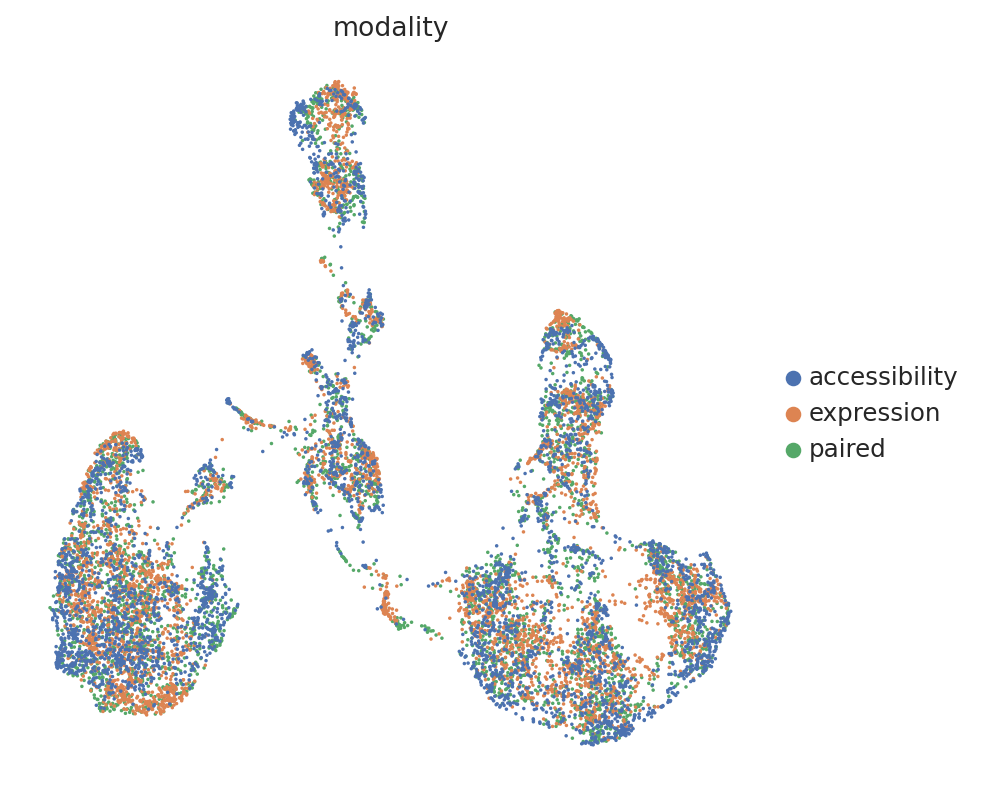

In [18]:
MULTIVI_LATENT_KEY = "X_multivi"

adata_mvi.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color="modality")

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_accessibility_estimates`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [19]:
imputed_expression = model.get_normalized_expression()

We can demonstrate this on some known marker genes:

First, T-cell marker CD3.

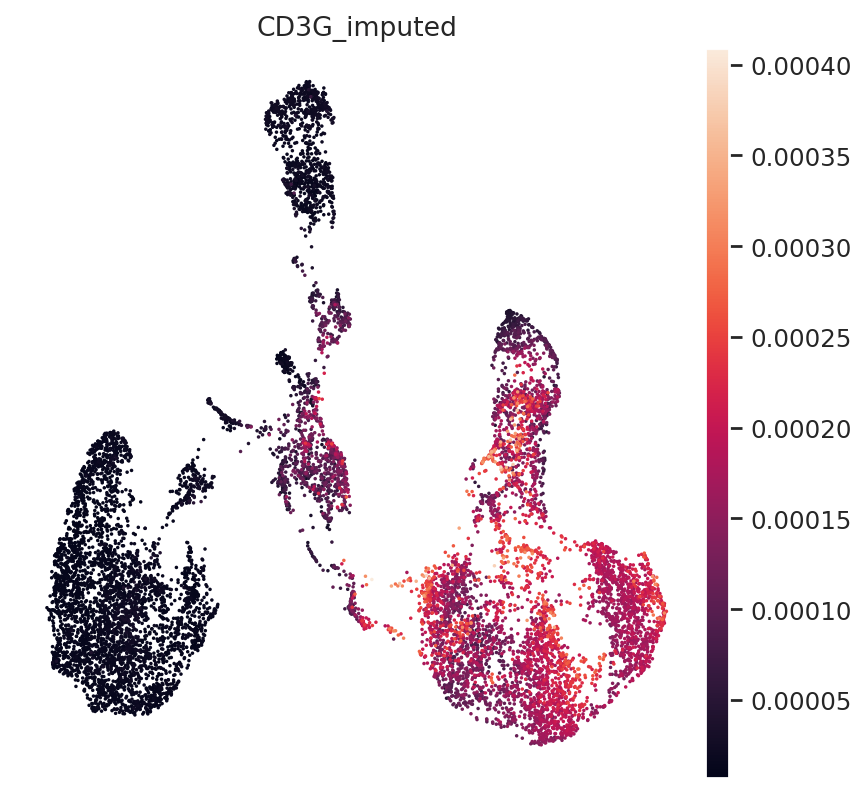

In [20]:
gene_idx = np.where(adata_mvi.var.index == "CD3G")[0]
adata_mvi.obs["CD3G_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="CD3G_imputed")

Next, NK-Cell marker gene NCAM1 (CD56):

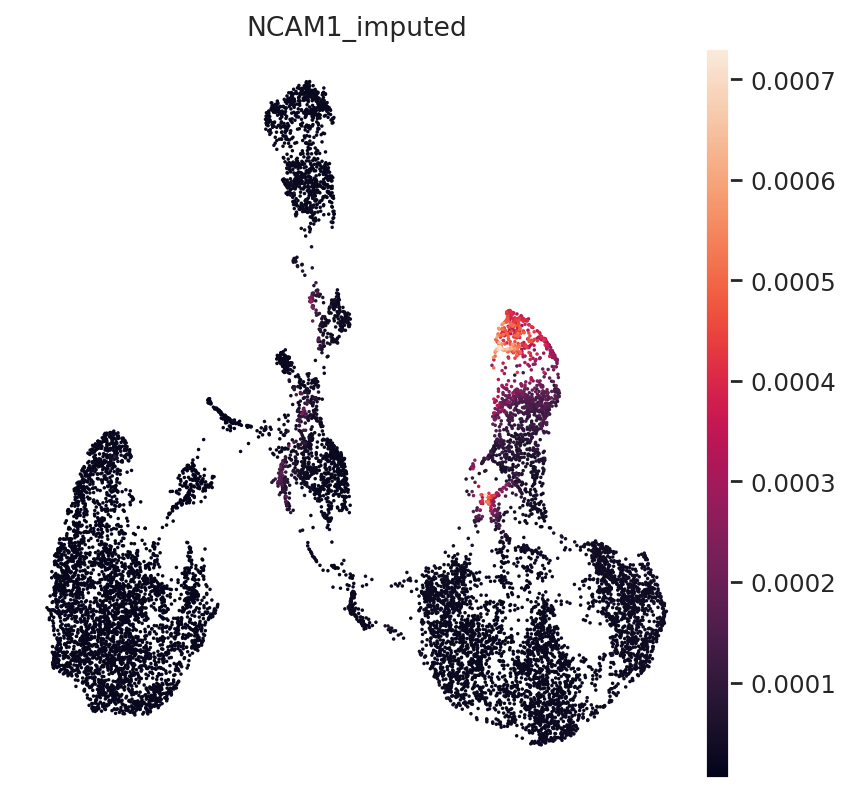

In [21]:
gene_idx = np.where(adata_mvi.var.index == "NCAM1")[0]
adata_mvi.obs["NCAM1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="NCAM1_imputed")

Finally, B-Cell Marker CD19:

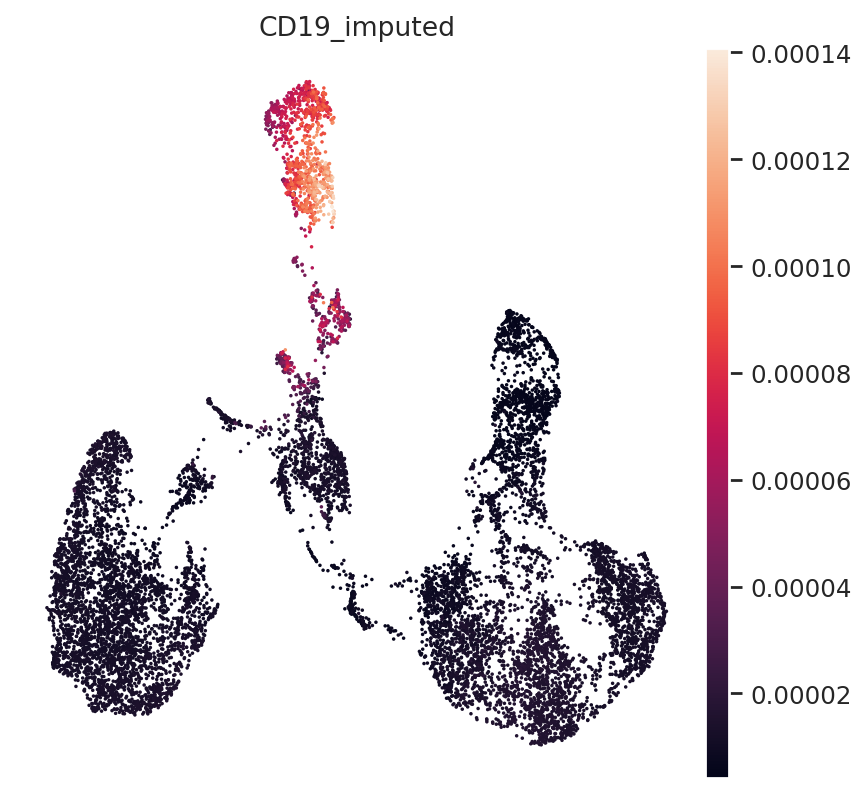

In [22]:
gene_idx = np.where(adata_mvi.var.index == "CD19")[0]
adata_mvi.obs["CD19_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="CD19_imputed")

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.